# Machine Learning Assigment

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from PIL import Image
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, voting_classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
import tensorflow as tf
from sklearn.svm import SVC
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, ZeroPadding2D
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier
import warnings
import random


warnings.filterwarnings("ignore")

# Import and Cleaning

In [99]:
# Importing data
df = pd.read_csv('attribute_list.csv', skiprows=1)#row 1 are for coloumns name so we skip it: skiprows=1

# reading pictures. Returning as np.array. Color level: RGB
#Black and white color saves us time 
#and is more simple to handle in binary decisions and 
#don't affect accuracy


def read_pic(name, as_black_white=False):   
    string = 'dataset/' + str(name) + '.png'
    if as_black_white == True:
        return(np.array(Image.open(string).convert(mode='L')))
    else:
        return(np.array(Image.open(string)))

# Cleaning data: data where each column are labeled "-1" are noises
def clean_data():
    tmp = df[['hair_color', 'eyeglasses', 'smiling', 'young', 'human']]
    tmp['sum'] = tmp.sum(axis=1)
    t = tmp[tmp['sum'] == -5]
    return(t.index + 1)
df.drop(labels=clean_data()-1, inplace=True)

# Converting (-1,1) to (0, 1)
df['eyeglasses'] = (df['eyeglasses'] + 1) / 2
df['smiling'] = (df['smiling'] + 1) / 2
df['young'] = (df['young'] + 1) / 2
df['human'] = (df['human'] + 1) / 2

df['eyeglasses'] = df['eyeglasses'].apply(lambda x: int(x))
df['smiling'] = df['smiling'].apply(lambda x: int(x))
df['young'] = df['young'].apply(lambda x: int(x))
df['human'] = df['human'].apply(lambda x: int(x))

# Importing Pictures
def import_pictures_bw(data, _as_black_white=True, for_hair=False):
    res = []
    if for_hair == True:
        df_hair = data[data['hair_color'] != -1]
        file_names = np.array(df_hair['file_name'])
        print("Number of pictures to load for hair: ", file_names.shape)
    else:
        file_names = np.array(data['file_name'])
        print("Number of pictures to load for binary case: ", file_names.shape)
    for k in file_names:
        res.append(read_pic(k, as_black_white=_as_black_white)) # Data are alredy cleaned
    return(np.array(res), file_names)



#just for test

#pics_color, fl_nm_col = import_pictures_bw(df)
#pics_color.shape # acces to an image: pics[name_of_img][x_pixel][y_pixel][RGB_color]



def createSets(file_names, prop=5./6): # Only takes np.array as arguments
    indexMax = int(prop*len(file_names))
    sample = np.random.permutation(len(file_names))
    return(sample, indexMax)

# Preprocessing for black and white pictures

### Import pictures in _black_ and _white_ and scaling.

In [103]:
################################# importing and scaling pictures for hair in b&w ###############################

pics_hair_bw, file_name_hair_bw = import_pictures_bw(df, _as_black_white=True, for_hair=True)
print(pics_hair_bw.shape)



################################ importing and scaling pictures for binary case in b&w ########################

pics_binary_bw, file_name_binary_bw = import_pictures_bw(df, _as_black_white=True, for_hair=False)
print(pics_binary_bw.shape)





Number of pictures to load for hair:  (3902,)
(3902, 256, 256)
Number of pictures to load for binary case:  (4565,)
(4565, 256, 256)


### Applying  PCA in B&W

In [104]:
pics_hair_bw_PCA = np.array([preprocessing.scale(pics_hair_bw[k]) for k in range(len(pics_hair_bw))])
pics_binary_bw_PCA = np.array([preprocessing.scale(pics_binary_bw[k]) for k in range(len(pics_binary_bw))])



# searching for number of component to keep
v_exp = np.cumsum(pca.explained_variance_ratio_)

def extract_var(tbl, x=.99):
    k = 0
    while tbl[k] < x:
        k = k + 1
    return(k)

k99 = extract_var(v_exp, x=.99)
pca99 = PCA(n_components=k99)

# First, ravel
def to_vector(data):
    res = []
    for k in range(len(data)):
        res.append(data[k].ravel())
    return(np.array(res))

pics_lin_hair_PCA = to_vector(data = pics_hair_bw_PCA)
pics_lin_binary_PCA = to_vector(data = pics_binary_bw_PCA)


######################################## Apply PCA for hair ###########################################
s = time.time()


pca = PCA()
pca.fit(pics_lin_hair_PCA)



X_hair_bw_PCA = pca99.fit_transform(pics_lin_hair_PCA)

print('X_hair_bw_PCA.shape', X_hair_bw_PCA.shape)
print('Time to compute the PCA for hair (99% precision): ' + str(int(100*(time.time() - s)/60)/100) + ' min')
print('')


######################################## Apply PCA for hair ###########################################


u = time.time()


pca = PCA()
pca.fit(pics_lin_binary_PCA)



X_binary_bw_PCA = pca99.fit_transform(pics_lin_binary_PCA)

print('X_binary_bw_PCA', X_binary_bw_PCA.shape)
print('Time to compute the PCA for binary case (99% precision): ' + str(int(100*(time.time() - u)/60)/100) + ' min')
print('')







X_hair_bw_PCA.shape (3902, 2809)
Time to compute the PCA for hair (99% precision): 5.17 min

X_binary_bw_PCA (4565, 2809)
Time to compute the PCA for binary case (99% precision): 6.19 min



### Applying NMF in B&W

In [105]:
######################################## Apply NMF for hair ###########################################


s = time.time()

pics_lin_hair_NMF = to_vector(data=pics_hair_bw)

#nmf.fit(pics_lin)
nmf = NMF(n_components=15)  #we used nmf with base 15
X_hair_bw = nmf.fit_transform(pics_lin_hair_NMF)
X_hair_bw_NMF = preprocessing.scale(X_hair_bw)



print('Time to compute nmf.fit_transform for hair: ' + str(int(100*(time.time() - s)/60)/100) + ' min')


######################################## Apply NMF for binary case ###########################################

t = time.time()

pics_lin_binary_NMF = to_vector(data=pics_binary_bw)

#nmf.fit(pics_lin)
nmf = NMF(n_components=15)  #we used nmf with base 15
X_binary_bw = nmf.fit_transform(pics_lin_binary_NMF)
X_binary_bw_NMF = preprocessing.scale(X_binary_bw)


print('Time to compute nmf.fit_transform for binary data case: ' + str(int(100*(time.time() - t)/60)/100) + ' min')



Time to compute nmf.fit_transform for hair: 2.01 min
Time to compute nmf.fit_transform for binary data case: 2.88 min


# Preprocessing in color

### Importing picture in color with hexadecimal code

In [106]:
# note that we could have used the following function to import pictures in color:
# import_pictures_bw(df, _as_black_white=False, for_hair=True) (with as_black_white set at False)
# But this would return images in rgb coloring with a shape of: 256*256*3 (3 dimension) 
# which is not adapted to certain 
# functions such a scaling. For ease we hence use the following code to convert rgb to hexadecimal
# and manipulate picture with shape 256*256 only (2D)


def rgb2dec(img):
    res = np.zeros(shape=(img.shape[0],img.shape[1]))
    for k in range (img.shape[0]):
        for l in range (img.shape[1]):
            r,g,b = img[k][l][0], img[k][l][1], img[k][l][2]
            hx = "#{:02x}{:02x}{:02x}".format(r,g,b)
            res[k][l] = int(hx[1:], 16)
    
    return(res)



def import_pictures_color(data, for_hair=False): #difference importing hair color data and others as we need to missing data for hair color
    res = []
    if for_hair == True:
        df2 = data[data['hair_color'] != -1]
        file_names = np.array(df2['file_name'])
        print("Number of pictures to load:", file_names.shape)
    else:
        file_names = np.array(data['file_name'])
        print("Number of pictures to load:", file_names.shape)
    for k in file_names:
        string = 'dataset/' + str(k) + '.png'
        tmp = np.array(Image.open(string))
        res.append(rgb2dec(tmp)) # Data are alredy cleaned
    return(np.array(res),file_names)
    
# Loading data

#if data 

compute = True
s = time.time()
if compute == True:
    
    s = time.time()
    
    colored_pic_for_hair, file_name_hair_col = import_pictures_color(df, for_hair=True)
    np.save('Colored_decimal_pictures_for_hair', colored_pic_for_hair)
    np.save('File_name_hair_colored_pic', file_name_hair_col)
    print('finish hair')
    colored_pic_binary_case, file_name_binary_col = import_pictures_color(df,for_hair=False)
    np.save('Colored_decimal_pictures_binary_case', colored_pic_binary_case)
    np.save('File_name_binary_colored_pic', file_name_binary_col)
    
    print("Time to compute this part:" + str(int(100*(time.time() - s)/60)/100) + ' min')
    compute = False
else:
   
    colored_pic_for_hair = np.load('Colored_decimal_pictures_for_hair.npy')
    colored_pic_binary_case = np.load('Colored_decimal_pictures_binary_case.npy')
    file_name_hair_col = np.load('File_name_hair_colored_pic')
    file_name_binary_col = np.load('File_name_binary_colored_pic')
    
    
print("Time to load data:" + str(int(100*(time.time() - s)/60)/100) + ' min')
print("Data Loaded!")
print("Colored_decimal_pictures_for_hair: ", colored_pic_for_hair.shape)
print("Colored_decimal_pictures_binary_case: ", colored_pic_binary_case.shape)   

Number of pictures to load: (3902,)
finish hair
Number of pictures to load: (4565,)
Time to compute this part:42.17 min
Time to load data:42.17 min
Data Loaded!
Colored_decimal_pictures_for_hair:  (3902, 256, 256)
Colored_decimal_pictures_binary_case:  (4565, 256, 256)


### Applying NMF in color

In [108]:




################################# NMF for hair in color ##########################################

s = time.time()

lin_pics_color_for_hair = to_vector(data=colored_pic_for_hair)

#nmf.fit(pics_lin)
nmf = NMF(n_components=15)
X_hair_col = nmf.fit_transform(lin_pics_color_for_hair)
X_hair_col_NMF = preprocessing.scale(X_hair_col)



print('Time to compute nmf.fit_transform for hair: ' + str(int(100*(time.time() - s)/60)/100) + ' min')

################################ NMF for binary cases in color ###################################

t = time.time()

lin_pics_color_binary_case = to_vector(data=colored_pic_binary_case)

#nmf.fit(pics_lin)
nmf = NMF(n_components=15)
X_binary_col = nmf.fit_transform(lin_pics_color_binary_case)
X_binary_col_NMF = preprocessing.scale(X_binary_col)
print('Time to compute nmf.fit_transform for binary data case: ' + str(int(100*(time.time() - t)/60)/100) + ' min')




# NMF gives more accuracy for colored data rather than pca

Time to compute nmf.fit_transform for hair: 1.68 min
Time to compute nmf.fit_transform for binary data case: 2.19 min


### Applying PCA in color

In [109]:
################################## PCA for hair in color ####################################

s = time.time()



X_hair_col_PCA = np.array([preprocessing.scale(colored_pic_for_hair[k]) for k in range(len(colored_pic_for_hair))])
X_hair_col_PCA = to_vector(data=X_hair_col_PCA)

pca = PCA()
pca.fit(X_hair_col_PCA)

# searching for number of component to keep


k99 = extract_var(v_exp, x=.99)
pca99 = PCA(n_components=k99)

X_hair_col_PCA = pca99.fit_transform(X_hair_col_PCA)

print('Time to compute PCA for hair in color: ' + str(int(100*(time.time() - s)/60)/100) + ' min')





################################## PCA for binary case in color ####################################

t = time.time()


X_binary_col_PCA = np.array([preprocessing.scale(colored_pic_binary_case[k]) for k in range(len(colored_pic_binary_case))])
X_binary_col_PCA = to_vector(data=X_binary_col_PCA)

pca = PCA()
pca.fit(X_binary_col_PCA)


# searching for number of component to keep


X_binary_col_PCA = pca99.fit_transform(X_binary_col_PCA)

print('Time to compute PCA for binary data case in color: ' + str(int(100*(time.time() - t)/60)/100) + ' min')










Time to compute PCA for hair in color: 5.63 min
Time to compute PCA for binary data case in color: 6.66 min


# Human or Cartoon 

### In black and white

In [107]:

Y_human = np.array(df['human'])


###################################### Cross validation score #############################################

#mlp classifier
c1_h_bw_NMF = np.mean(cross_val_score(MLPClassifier(), X_binary_bw_NMF, Y_human, cv=6))
print('Cross Validation score for MLP classifier with NMF preprocessing: ' + str(100*c1_h_bw_NMF) + '%')

c1_h_bw_PCA = np.mean(cross_val_score(MLPClassifier(), X_binary_bw_PCA, Y_human, cv=6))
print('Cross Validation score for MLP classifier with PCA preprocessing: ' + str(100*c1_h_bw_PCA) + '%')
print('')


# Random Forest classifier (gini)
c2_h_bw_NMF = np.mean(cross_val_score(RandomForestClassifier(criterion='gini'), X_binary_bw_NMF, Y_human, cv=6))
print('Cross Validation score for Random Forest classifier (gini) with NMF preprocessing: ' + str(100*c2_h_bw_NMF) + '%')

c2_h_bw_PCA = np.mean(cross_val_score(RandomForestClassifier(criterion='gini'), X_binary_bw_PCA, Y_human, cv=6))
print('Cross Validation score for Random Forest classifier (gini) with PCA preprocessing: ' + str(100*c2_h_bw_PCA) + '%')
print('')



# SVM linear kernel
c3_h_bw_NMF = np.mean(cross_val_score(SVC(kernel='linear'), X_binary_bw_NMF, Y_human, cv=6))
print('Cross Validation score for SVM linear kernel with NMF preprocessing: ' + str(100*c3_h_bw_NMF) + '%')

c3_h_bw_PCA = np.mean(cross_val_score(SVC(kernel='linear'), X_binary_bw_PCA, Y_human, cv=6))
print('Cross Validation score for SVM linear kernel with PCA preprocessing: ' + str(100*c3_h_bw_PCA) + '%')
print('')



# SVM polynomial kernel
c4_h_bw_NMF = np.mean(cross_val_score(SVC(kernel='poly'), X_binary_bw_NMF, Y_human, cv=6))
print('Cross Validation score for SVM polynomial kernel with NMF preprocessing: ' + str(100*c4_h_bw_NMF) + '%')

c4_h_bw_PCA = np.mean(cross_val_score(SVC(kernel='poly'), X_binary_bw_PCA, Y_human, cv=6))
print('Cross Validation score for SVM polynomial kernel with PCA preprocessing: ' + str(100*c4_h_bw_PCA) + '%')
print('')




Cross Validation score for MLP classifier with NMF preprocessing: 99.32066480010423%
Cross Validation score for MLP classifier with PCA preprocessing: 98.62003314709459%

Cross Validation score for Random Forest classifier (gini) with NMF preprocessing: 97.5905402744672%
Cross Validation score for Random Forest classifier (gini) with PCA preprocessing: 83.74381687575033%

Cross Validation score for SVM linear kernel with NMF preprocessing: 97.23966293021381%
Cross Validation score for SVM linear kernel with PCA preprocessing: 98.99206293452201%

Cross Validation score for SVM polynomial kernel with NMF preprocessing: 98.1159348995201%
Cross Validation score for SVM polynomial kernel with PCA preprocessing: 97.63393945483281%



### In color

In [95]:
# Various splitting and naming
smpl, indM = createSets(fl_nm_col)
names_for_train, names_for_test = smpl[:indM], smpl[indM:]
print(names_for_train.shape, names_for_test.shape, names_for_train.shape[0] + names_for_test.shape[0])


X_train, X_test = X_binary_col_NMF[names_for_train], X_binary_col_NMF[names_for_test]
Y_train, Y_test = Y_human[names_for_train], Y_human[names_for_test]

print(X_train.shape, X_test.shape, X_train.shape[0] + X_test.shape[0])

# Toy example
clf = MLPClassifier()
clf.fit(X_train, Y_train)


# Export data

score = clf.score(X_test, Y_test)
predictions = clf.predict(X_test)

d = {'X test (file name)': [str(names_for_test[k])+'.png' for k in range(len(names_for_test))], 'Y predicted': predictions}
df_exp = pd.DataFrame(data=d)
print('Score of classifier:', score)
# pd.DataFrame(X_names, predictions, columns=['X test (file name)', 'Y predicted'])
# add target in csv
# df_exp['Y target'] = Y_test
# print(df_exp)
print(df_exp.shape)

df_exp.loc[-1] = [str(score), np.nan]
df_exp.index = df_exp.index + 1
df_exp = df_exp.sort_index()  # sorting by index
# df_exp['Y predicted'][1:].apply(lambda x : int(x))
# print(df_exp)
print(df_exp.shape)
df_exp.to_csv(path_or_buf='task_1.csv', header=False, index=False)

(3804,) (761,) 4565
(3804, 15) (761, 15) 4565
Score of classifier: 0.9894875164257556
(761, 2)
(762, 2)


In [59]:
Y_human = np.array(df['human'])


###################################### Cross validation score #############################################

#mlp classifier
c1_h_col_NMF = np.mean(cross_val_score(MLPClassifier(), X_binary_col_NMF, Y_human, cv=6))
print('Cross Validation score for MLP classifier with NMF preprocessing: ' + str(100*c1_h_col_NMF) + '%')

c1_h_col_PCA = np.mean(cross_val_score(MLPClassifier(), X_binary_col_PCA, Y_human, cv=6))
print('Cross Validation score for MLP classifier with PCA preprocessing: ' + str(100*c1_h_col_PCA) + '%')
print('')


# Random Forest classifier (gini)
c2_h_col_NMF = np.mean(cross_val_score(RandomForestClassifier(criterion='gini'), X_binary_col_NMF, Y_human, cv=6))
print('Cross Validation score for Random Forest classifier (gini) with NMF preprocessing: ' + str(100*c2_h_col_NMF) + '%')

c2_h_col_PCA = np.mean(cross_val_score(RandomForestClassifier(criterion='gini'), X_binary_col_PCA, Y_human, cv=6))
print('Cross Validation score for Random Forest classifier (gini) with PCA preprocessing: ' + str(100*c2_h_col_PCA) + '%')
print('')


# SVM linear kernel
c3_h_col_NMF = np.mean(cross_val_score(SVC(kernel='linear'), X_binary_col_NMF, Y_human, cv=6))
print('Cross Validation score for SVM linear kernel with NMF preprocessing: ' + str(100*c3_h_col_NMF) + '%')

c3_h_col_PCA = np.mean(cross_val_score(SVC(kernel='linear'), X_binary_col_PCA, Y_human, cv=6))
print('Cross Validation score for SVM linear kernel with PCA preprocessing: ' + str(100*c3_h_col_PCA) + '%')
print('')



# SVM polynomial kernel
c4_h_col_NMF = np.mean(cross_val_score(SVC(kernel='poly'), X_binary_col_NMF, Y_human, cv=6))
print('Cross Validation score for SVM polynomial kernel with NMF preprocessing: ' + str(100*c4_h_col_NMF) + '%')

c4_h_col_PCA = np.mean(cross_val_score(SVC(kernel='poly'), X_binary_col_PCA, Y_human, cv=6))
print('Cross Validation score for SVM polynomial kernel with PCA preprocessing: ' + str(100*c4_h_col_PCA) + '%')
print('')





Cross Validation score for MLP classifier with NMF preprocessing: 99.12358424766029%
Cross Validation score for MLP classifier with PCA preprocessing: 98.79509757490287%

Cross Validation score for Random Forest classifier (gini) with NMF preprocessing: 97.30559664074427%
Cross Validation score for Random Forest classifier (gini) with PCA preprocessing: 84.5557660944571%

Cross Validation score for SVM linear kernel with NMF preprocessing: 96.8890161228809%
Cross Validation score for SVM linear kernel with PCA preprocessing: 99.21115968723704%

Cross Validation score for SVM polynomial kernel with NMF preprocessing: 98.20345270486669%
Cross Validation score for SVM polynomial kernel with PCA preprocessing: 97.54624882243132%



# Young or old 

### In black and white

In [110]:
Y_young = np.array(df['young'])



###################################### Cross validation score #############################################

#mlp classifier
c1_y_bw_NMF = np.mean(cross_val_score(MLPClassifier(), X_binary_bw_NMF, Y_young, cv=6))
print('Cross Validation score for MLP classifier with NMF preprocessing: ' + str(100*c1_y_bw_NMF) + '%')

c1_y_bw_PCA = np.mean(cross_val_score(MLPClassifier(), X_binary_bw_PCA, Y_young, cv=6))
print('Cross Validation score for MLP classifier with PCA preprocessing: ' + str(100*c1_y_bw_PCA) + '%')
print('')



# Random Forest classifier (gini)
c2_y_bw_NMF = np.mean(cross_val_score(RandomForestClassifier(criterion='gini'), X_binary_bw_NMF, Y_young, cv=6))
print('Cross Validation score for Random Forest classifier (gini) with NMF preprocessing: ' + str(100*c2_y_bw_NMF) + '%')

c2_y_bw_PCA = np.mean(cross_val_score(RandomForestClassifier(criterion='gini'), X_binary_bw_PCA, Y_young, cv=6))
print('Cross Validation score for Random Forest classifier (gini) with PCA preprocessing: ' + str(100*c2_y_bw_PCA) + '%')
print('')



# SVM linear kernel
c3_y_bw_NMF = np.mean(cross_val_score(SVC(kernel='linear'), X_binary_bw_NMF, Y_young, cv=6))
print('Cross Validation score for SVM linear kernel with NMF preprocessing: ' + str(100*c3_y_bw_NMF) + '%')

c3_y_bw_PCA = np.mean(cross_val_score(SVC(kernel='linear'), X_binary_bw_PCA, Y_young, cv=6))
print('Cross Validation score for SVM linear kernel with PCA preprocessing: ' + str(100*c3_y_bw_PCA) + '%')
print('')




# SVM polynomial kernel
c4_y_bw_NMF = np.mean(cross_val_score(SVC(kernel='poly'), X_binary_bw_NMF, Y_young, cv=6))
print('Cross Validation score for SVM polynomial kernel with NMF preprocessing: ' + str(100*c4_y_bw_NMF) + '%')

c4_y_bw_PCA = np.mean(cross_val_score(SVC(kernel='poly'), X_binary_bw_PCA, Y_young, cv=6))
print('Cross Validation score for SVM polynomial kernel with PCA preprocessing: ' + str(100*c4_y_bw_PCA) + '%')
print('')

Cross Validation score for MLP classifier with NMF preprocessing: 79.18949398174595%
Cross Validation score for MLP classifier with PCA preprocessing: 77.08682217077799%

Cross Validation score for Random Forest classifier (gini) with NMF preprocessing: 78.02871055980717%
Cross Validation score for Random Forest classifier (gini) with PCA preprocessing: 75.00590682786824%

Cross Validation score for SVM linear kernel with NMF preprocessing: 79.16762239649846%
Cross Validation score for SVM linear kernel with PCA preprocessing: 72.13580627444045%

Cross Validation score for SVM polynomial kernel with NMF preprocessing: 79.29911496815717%
Cross Validation score for SVM polynomial kernel with PCA preprocessing: 79.2770124678118%



### In color

In [60]:
Y_young = np.array(df['young'])


###################################### Cross validation score #############################################

#mlp classifier
c1_y_col_NMF = np.mean(cross_val_score(MLPClassifier(), X_binary_col_NMF, Y_young, cv=6))
print('Cross Validation score for MLP classifier with NMF preprocessing: ' + str(100*c1_y_col_NMF) + '%')

c1_y_col_PCA = np.mean(cross_val_score(MLPClassifier(), X_binary_col_PCA, Y_young, cv=6))
print('Cross Validation score for MLP classifier with PCA preprocessing: ' + str(100*c1_y_col_PCA) + '%')

print('')




# Random Forest classifier (gini)
c2_y_col_NMF = np.mean(cross_val_score(RandomForestClassifier(criterion='gini'), X_binary_col_NMF, Y_young, cv=6))
print('Cross Validation score for Random Forest classifier (gini) with NMF preprocessing: ' + str(100*c2_y_col_NMF) + '%')

c2_y_col_PCA = np.mean(cross_val_score(RandomForestClassifier(criterion='gini'), X_binary_col_PCA, Y_young, cv=6))
print('Cross Validation score for Random Forest classifier (gini) with PCA preprocessing: ' + str(100*c2_y_col_PCA) + '%')

print('')



# SVM linear kernel
c3_y_col_NMF = np.mean(cross_val_score(SVC(kernel='linear'), X_binary_col_NMF, Y_young, cv=6))
print('Cross Validation score for SVM linear kernel with NMF preprocessing: ' + str(100*c3_y_col_NMF) + '%')

c3_y_col_PCA = np.mean(cross_val_score(SVC(kernel='linear'), X_binary_col_PCA, Y_young, cv=6))
print('Cross Validation score for SVM linear kernel with PCA preprocessing: ' + str(100*c3_y_col_PCA) + '%')

print('')



# SVM polynomial kernel
c4_y_col_NMF = np.mean(cross_val_score(SVC(kernel='poly'), X_binary_col_NMF, Y_young, cv=6))
print('Cross Validation score for SVM polynomial kernel with NMF preprocessing: ' + str(100*c4_y_col_NMF) + '%')

c4_y_col_PCA = np.mean(cross_val_score(SVC(kernel='poly'), X_binary_col_PCA, Y_young, cv=6))
print('Cross Validation score for SVM polynomial kernel with PCA preprocessing: ' + str(100*c4_y_col_PCA) + '%')

print('')







Cross Validation score for MLP classifier with NMF preprocessing: 79.51875796025533%
Cross Validation score for MLP classifier with PCA preprocessing: 75.13693968712448%

Cross Validation score for Random Forest classifier (gini) with NMF preprocessing: 78.18288121775772%
Cross Validation score for Random Forest classifier (gini) with PCA preprocessing: 74.52330728266134%

Cross Validation score for SVM linear kernel with NMF preprocessing: 79.16762239649846%
Cross Validation score for SVM linear kernel with PCA preprocessing: 68.56504434326234%

Cross Validation score for SVM polynomial kernel with NMF preprocessing: 79.54011257704758%
Cross Validation score for SVM polynomial kernel with PCA preprocessing: 79.29885584102804%



# Smiling or not Smiling 

### In black and white

In [111]:
Y_smiling = np.array(df['smiling'])



###################################### Cross validation score #############################################

#mlp classifier
c1_s_bw_NMF = np.mean(cross_val_score(MLPClassifier(), X_binary_bw_NMF, Y_smiling, cv=6))
print('Cross Validation score for MLP classifier with NMF preprocessing: ' + str(100*c1_s_bw_NMF) + '%')

c1_s_bw_PCA = np.mean(cross_val_score(MLPClassifier(), X_binary_bw_PCA, Y_smiling, cv=6))
print('Cross Validation score for MLP classifier with PCA preprocessing: ' + str(100*c1_s_bw_PCA) + '%')
print('')



# Random Forest classifier (gini)
c2_s_bw_NMF = np.mean(cross_val_score(RandomForestClassifier(criterion='gini'), X_binary_bw_NMF, Y_smiling, cv=6))
print('Cross Validation score for Random Forest classifier (gini) with NMF preprocessing: ' + str(100*c2_s_bw_NMF) + '%')

c2_s_bw_PCA = np.mean(cross_val_score(RandomForestClassifier(criterion='gini'), X_binary_bw_PCA, Y_smiling, cv=6))
print('Cross Validation score for Random Forest classifier (gini) with PCA preprocessing: ' + str(100*c2_s_bw_PCA) + '%')
print('')



# SVM linear kernel
c3_s_bw_NMF = np.mean(cross_val_score(SVC(kernel='linear'), X_binary_bw_NMF, Y_smiling, cv=6))
print('Cross Validation score for SVM linear kernel with NMF preprocessing: ' + str(100*c3_s_bw_NMF) + '%')

c3_s_bw_PCA = np.mean(cross_val_score(SVC(kernel='linear'), X_binary_bw_PCA, Y_smiling, cv=6))
print('Cross Validation score for SVM linear kernel with PCA preprocessing: ' + str(100*c3_s_bw_PCA) + '%')
print('')




# SVM polynomial kernel
c4_s_bw_NMF = np.mean(cross_val_score(SVC(kernel='poly'), X_binary_bw_NMF, Y_smiling, cv=6))
print('Cross Validation score for SVM polynomial kernel with NMF preprocessing: ' + str(100*c4_s_bw_NMF) + '%')

c4_s_bw_PCA = np.mean(cross_val_score(SVC(kernel='poly'), X_binary_bw_PCA, Y_smiling, cv=6))
print('Cross Validation score for SVM polynomial kernel with PCA preprocessing: ' + str(100*c4_s_bw_PCA) + '%')
print('')





Cross Validation score for MLP classifier with NMF preprocessing: 81.38038602469456%
Cross Validation score for MLP classifier with PCA preprocessing: 87.40388803844363%

Cross Validation score for Random Forest classifier (gini) with NMF preprocessing: 79.62672056329426%
Cross Validation score for Random Forest classifier (gini) with PCA preprocessing: 79.01452893894869%

Cross Validation score for SVM linear kernel with NMF preprocessing: 79.60571243260199%
Cross Validation score for SVM linear kernel with PCA preprocessing: 87.75456396543349%

Cross Validation score for SVM polynomial kernel with NMF preprocessing: 80.76655295932257%
Cross Validation score for SVM polynomial kernel with PCA preprocessing: 85.36666034959201%



### In color

In [61]:
Y_smiling = np.array(df['smiling'])


###################################### Cross validation score #############################################

#mlp classifier
c1_s_col_NMF = np.mean(cross_val_score(MLPClassifier(), X_binary_col_NMF, Y_smiling, cv=6))
print('Cross Validation score for MLP classifier with NMF preprocessing: ' + str(100*c1_s_col_NMF) + '%')

c1_s_col_PCA = np.mean(cross_val_score(MLPClassifier(), X_binary_col_PCA, Y_smiling, cv=6))
print('Cross Validation score for MLP classifier with PCA preprocessing: ' + str(100*c1_s_col_PCA) + '%')
print('')


# Random Forest classifier (gini)
c2_s_col_NMF = np.mean(cross_val_score(RandomForestClassifier(criterion='gini'), X_binary_col_NMF, Y_smiling, cv=6))
print('Cross Validation score for Random Forest classifier (gini) with NMF preprocessing : ' + str(100*c2_s_col_NMF) + '%')

c2_s_col_PCA = np.mean(cross_val_score(RandomForestClassifier(criterion='gini'), X_binary_col_PCA, Y_smiling, cv=6))
print('Cross Validation score for Random Forest classifier (gini) with PCA preprocessing : ' + str(100*c2_s_col_PCA) + '%')
print('')



# SVM linear kernel
c3_s_col_NMF = np.mean(cross_val_score(SVC(kernel='linear'), X_binary_col_NMF, Y_smiling, cv=6))
print('Cross Validation score for SVM linear kernel with NMF preprocessing: ' + str(100*c3_s_col_NMF) + '%')

c3_s_col_PCA = np.mean(cross_val_score(SVC(kernel='linear'), X_binary_col_PCA, Y_smiling, cv=6))
print('Cross Validation score for SVM linear kernel with PCA preprocessing: ' + str(100*c3_s_col_PCA) + '%')
print('')



# SVM polynomial kernel
c4_s_col_NMF = np.mean(cross_val_score(SVC(kernel='poly'), X_binary_col_NMF, Y_smiling, cv=6))
print('Cross Validation score for SVM polynomial kernel with NMF preprocessing: ' + str(100*c4_s_col_NMF) + '%')

c4_s_col_PCA = np.mean(cross_val_score(SVC(kernel='poly'), X_binary_col_PCA, Y_smiling, cv=6))
print('Cross Validation score for SVM polynomial kernel with PCA preprocessing: ' + str(100*c4_s_col_PCA) + '%')
print('')




Cross Validation score for MLP classifier with NMF preprocessing: 80.832198271796%
Cross Validation score for MLP classifier with PCA preprocessing: 86.55029483614844%

Cross Validation score for Random Forest classifier (gini) with NMF preprocessing : 79.43087778535947%
Cross Validation score for Random Forest classifier (gini) with PCA preprocessing : 78.00638969985242%

Cross Validation score for SVM linear kernel with NMF preprocessing: 79.60571243260199%
Cross Validation score for SVM linear kernel with PCA preprocessing: 86.63732411197755%

Cross Validation score for SVM polynomial kernel with NMF preprocessing: 81.37989658755136%
Cross Validation score for SVM polynomial kernel with PCA preprocessing: 84.07435659777606%



# With or without eyeglasses 

### In black and white

In [112]:
Y_eyeglasses = np.array(df['eyeglasses'])



###################################### Cross validation score #############################################

#mlp classifier
c1_e_bw_NMF = np.mean(cross_val_score(MLPClassifier(), X_binary_bw_NMF, Y_eyeglasses, cv=6))
print('Cross Validation score for MLP classifier with NMF preprocessing: ' + str(100*c1_e_bw_NMF) + '%')

c1_e_bw_PCA = np.mean(cross_val_score(MLPClassifier(), X_binary_bw_PCA, Y_eyeglasses, cv=6))
print('Cross Validation score for MLP classifier with PCA preprocessing: ' + str(100*c1_e_bw_PCA) + '%')
print('')



# Random Forest classifier (gini)
c2_e_bw_NMF = np.mean(cross_val_score(RandomForestClassifier(criterion='gini'), X_binary_bw_NMF, Y_eyeglasses , cv=6))
print('Cross Validation score for Random Forest classifier (gini) with NMF preprocessing: ' + str(100*c2_e_bw_NMF) + '%')

c2_e_bw_PCA = np.mean(cross_val_score(RandomForestClassifier(criterion='gini'), X_binary_bw_PCA, Y_eyeglasses , cv=6))
print('Cross Validation score for Random Forest classifier (gini) with PCA preprocessing: ' + str(100*c2_e_bw_PCA) + '%')
print('')



# SVM linear kernel
c3_e_bw_NMF = np.mean(cross_val_score(SVC(kernel='linear'), X_binary_bw_NMF, Y_eyeglasses , cv=6))
print('Cross Validation score for SVM linear kernel with NMF preprocessing: ' + str(100*c3_e_bw_NMF) + '%')

c3_e_bw_PCA = np.mean(cross_val_score(SVC(kernel='linear'), X_binary_bw_PCA, Y_eyeglasses , cv=6))
print('Cross Validation score for SVM linear kernel with PCA preprocessing: ' + str(100*c3_e_bw_PCA) + '%')
print('')



# SVM polynomial kernel
c4_e_bw_NMF = np.mean(cross_val_score(SVC(kernel='poly'), X_binary_bw_NMF, Y_eyeglasses, cv=6))
print('Cross Validation score for SVM polynomial kernel with NMF preprocessing: ' + str(100*c4_e_bw_NMF) + '%')

c4_e_bw_PCA = np.mean(cross_val_score(SVC(kernel='poly'), X_binary_bw_PCA, Y_eyeglasses, cv=6))
print('Cross Validation score for SVM polynomial kernel with PCA preprocessing: ' + str(100*c4_e_bw_PCA) + '%')
print('')




Cross Validation score for MLP classifier with NMF preprocessing: 83.28591011891893%
Cross Validation score for MLP classifier with PCA preprocessing: 85.78265726414878%

Cross Validation score for Random Forest classifier (gini) with NMF preprocessing: 79.4744961573247%
Cross Validation score for Random Forest classifier (gini) with PCA preprocessing: 72.46397656401601%

Cross Validation score for SVM linear kernel with NMF preprocessing: 81.33677514064112%
Cross Validation score for SVM linear kernel with PCA preprocessing: 85.3016404668415%

Cross Validation score for SVM polynomial kernel with NMF preprocessing: 80.70106927985408%
Cross Validation score for SVM polynomial kernel with PCA preprocessing: 85.2572049292303%



### In color 

In [62]:
Y_eyeglasses = np.array(df['eyeglasses'])


###################################### Cross validation score #############################################

#mlp classifier
c1_e_col_NMF = np.mean(cross_val_score(MLPClassifier(), X_binary_col_NMF, Y_eyeglasses, cv=6))
print('Cross Validation score for MLP classifier with NMF preprocessing : ' + str(100*c1_e_col_NMF) + '%')

c1_e_col_PCA = np.mean(cross_val_score(MLPClassifier(), X_binary_col_PCA, Y_eyeglasses, cv=6))
print('Cross Validation score for MLP classifier with PCA preprocessing : ' + str(100*c1_e_col_PCA) + '%')
print('')


# Random Forest classifier (gini)
c2_e_col_NMF = np.mean(cross_val_score(RandomForestClassifier(criterion='gini'), X_binary_col_NMF, Y_eyeglasses, cv=6))
print('Cross Validation score for Random Forest classifier (gini) with NMF preprocessing : ' + str(100*c2_e_col_NMF) + '%')

c2_e_col_PCA = np.mean(cross_val_score(RandomForestClassifier(criterion='gini'), X_binary_col_PCA, Y_eyeglasses, cv=6))
print('Cross Validation score for Random Forest classifier (gini) with PCA preprocessing : ' + str(100*c2_e_col_PCA) + '%')
print('')



# SVM linear kernel
c3_e_col_NMF = np.mean(cross_val_score(SVC(kernel='linear'), X_binary_col_NMF, Y_eyeglasses, cv=6))
print('Cross Validation score for SVM linear kernel with NMF preprocessing: ' + str(100*c3_e_col_NMF) + '%')

c3_e_col_PCA = np.mean(cross_val_score(SVC(kernel='linear'), X_binary_col_PCA, Y_eyeglasses, cv=6))
print('Cross Validation score for SVM linear kernel with PCA preprocessing: ' + str(100*c3_e_col_PCA) + '%')
print('')



# SVM polynomial kernel
c4_e_col_NMF = np.mean(cross_val_score(SVC(kernel='poly'), X_binary_col_NMF, Y_eyeglasses, cv=6))
print('Cross Validation score for SVM polynomial kernel with NMF preprocessing: ' + str(100*c4_e_col_NMF) + '%')

c4_e_col_PCA = np.mean(cross_val_score(SVC(kernel='poly'), X_binary_col_PCA, Y_eyeglasses, cv=6))
print('Cross Validation score for SVM polynomial kernel with PCA preprocessing: ' + str(100*c4_e_col_PCA) + '%')
print('')




Cross Validation score for MLP classifier with NMF preprocessing : 84.1183795438842%
Cross Validation score for MLP classifier with PCA preprocessing : 84.95082007609896%

Cross Validation score for Random Forest classifier (gini) with NMF preprocessing : 81.27003576105652%
Cross Validation score for Random Forest classifier (gini) with PCA preprocessing : 72.26580209573189%

Cross Validation score for SVM linear kernel with NMF preprocessing: 83.066640539149%
Cross Validation score for SVM linear kernel with PCA preprocessing: 83.61497252889382%

Cross Validation score for SVM polynomial kernel with NMF preprocessing: 80.78852967787698%
Cross Validation score for SVM polynomial kernel with PCA preprocessing: 85.0165525962723%



# Multiclass approach

In [56]:
s = time.time()

Y_multi = np.array(df[['human', 'young','eyeglasses','eyeglasses']])

X_train_multi, X_test_multi, Y_train_multi, Y_test_multi = train_test_split(X_binary_col, Y_multi, test_size=0.3)

# Cross validation score
c1_multi = np.mean(cross_val_score(RandomForestClassifier(n_estimators=5000, criterion='entropy'), X_binary_col, Y_multi, cv=6))
print('Cross Validation score: ' + str(100*c1_multi) + '%')

#mlp classifier
c2_multi = np.mean(cross_val_score(MLPClassifier(), X_binary_col, Y_multi, cv=6))
print('Cross Validation score for MLP classifier : ' + str(100*c2_multi) + '%')

# K-NN
c3_multi = np.mean(cross_val_score(KNeighborsClassifier(n_neighbors=300), X_binary_col, Y_multi, cv=6))
print('Cross Validation score for SVM polynomial kernel : ' + str(100*c3_multi) + '%')
       


print("Time to compute this part:" + str(int(100*(time.time() - s)/60)/100) + ' min')

Cross Validation score: 79.0575650690458%
Cross Validation score for MLP classifier : 78.88258754639556%
Cross Validation score for SVM polynomial kernel : 77.1954607280356%
Time to compute this part:8.45 min


# Hair color

In [71]:
#defining Y data for hair

df3 = df[df['hair_color'] != -1]
Y_hair_color = np.array(df3['hair_color'])

#we remove -1 values as they 

## Convolution

### Model creation

In [25]:
s = time.time()

#create model
model = Sequential()



#add model layers


model.add(Conv2D(nb_filter=16, activation='relu', nb_row=9, nb_col=9, border_mode='same', input_shape=(256, 256, 3)))
model.add(Conv2D(nb_filter=32, activation='relu', nb_row=9, nb_col=9, border_mode='same'))
model.add(Conv2D(nb_filter=32, activation='relu', nb_row=9, nb_col=9, border_mode='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))



model.add(Flatten())

model.add(Dense(output_dim=512, activation = 'tanh'))

model.add(Dense(output_dim=256, activation = 'tanh'))

model.add(Dense(output_dim=6, input_dim=256, activation='softmax'))

'''model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
'''
'''#model.add(Dropout(0.2))
model.add(Flatten())

model.add(Dense(128, activation='softmax'))
model.add(Dense(6, activation='softmax'))
'''
#Compiling
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])





### Train and test the model with black and white data

In [28]:


#impotring pictures for hair color as black and whigte. we delete "-1" values because they are missing values

#pics_hair_col_conv = import_pictures(df_hair, _as_black_white=False)


# Splitting for black and white
X_train_hair_col_conv, X_test_hair_col_conv, Y_train_hair_col_conv, Y_test_hair_col_conv = train_test_split(pics_no_noise, 
                                                                                    Y_hair_color, test_size=0.2)

'''a,b,c = X_train_hair_bw.shape
d,e,f = X_test_hair_bw.shape
X_train_hair_bw = X_train_hair_bw.reshape(a,b,c,1)
X_test_hair_bw = X_test_hair_bw.reshape(d,e,f,1)
Y_train_hair_bw = to_categorical(Y_train_hair_bw)
Y_test_hair_bw = to_categorical(Y_test_hair_bw)'''



Y_train_hair_col_conv = to_categorical(Y_train_hair_col_conv)
Y_test_hair_col_conv = to_categorical(Y_test_hair_col_conv)

model.fit(X_train_hair_col_conv, Y_train_hair_col_conv, validation_data=(X_test_hair_col_conv, Y_test_hair_col_conv), epochs=1)








ValueError: Found input variables with inconsistent numbers of samples: [4565, 3902]

In [ ]:
df3 = df[df['hair_color'] != -1]
Y_hair_color = np.array(df3['hair_color'])
clf_ada = AdaBoostClassifier(n_estimators=3000)
scores = cross_val_score(clf_ada, X_hair_col, Y_hair_color, cv=6)
scores.mean()                    



### ML Classifier

### SVM Poly

In [40]:
s = time.time()
df3 = df[df['hair_color'] != -1]
Y_hair_color = np.array(df3['hair_color'])
c1_hair = np.mean(cross_val_score(MLPClassifier(), X_hair_col, Y_hair_color, cv=6))

print('Cross Validation score: ' + str(100*c1_hair) + '%')
print("Time to compute this part: " + str(int(100*(time.time() - s)/60)/100) + ' min')


Cross Validation score: 61.22240074058175%
Time to compute this part: 0.22 min


In [60]:
dftest = df[df['hair_color'] != -1] 
Y_hair_color = np.array(df3['hair_color'])
pics_hair = import_pictures(dftest, _as_black_white=True)
pics_lin_hair = to_vector(data=pics_hair)

nmf = NMF(n_components=15)
W = nmf.fit_transform(pics_lin_hair)
W = preprocessing.scale(W)

Y_hair_test = np.array(dftest['hair_color'])
c1_hair = np.mean(cross_val_score(MLPClassifier(), X_hair_col, Y_hair_color, cv=6))
                       
print('Cross Validation score: ' + str(100*c1_hair) + '%')
                  
                  

Cross Validation score: 60.81555680774784%


In [130]:
df3 = df[df['hair_color'] != -1]
Y_hair_color = np.array(df3['hair_color'])

c16 = np.mean(cross_val_score(SVC(kernel='linear'), X_hair_bw_PCA, Y_hair_color, cv=6))
print('Cross Validation score: ' + str(100*c16) + '%')


Cross Validation score: 50.33360935173713%


In [ ]:
#over 1000 n estimator, it is a flat curve converging to 67%, so in order to save time, we keep n not great

c1111 = np.mean(cross_val_score(RandomForestClassifier(n_estimators=1000, criterion='entropy'), X_hair_col_PCA, Y_hair_color, cv=6))

print('Cross Validation score: ' + str(100*c1111) + '%')



In [126]:
df3 = df[df['hair_color'] != -1]
dftest = df[df['hair_color'] != -1] 
Y_hair_color = np.array(df3['hair_color'])
c15 = np.mean(cross_val_score(SVC(kernel='poly'), set_contrast, Y_hair_color, cv=6))
print('Cross Validation score: ' + str(100*c15) + '%')


NameError: name 'set_contrast' is not defined

# Plotting accuracy for each classifier with different preprocessing (PCA and NMF)

### Human or cartoon

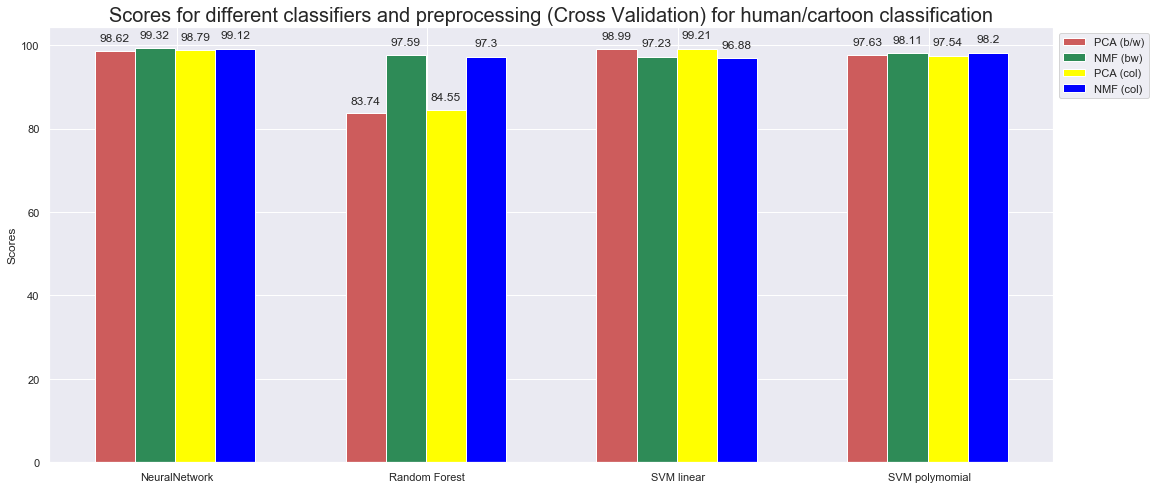

In [125]:
sns.set()
def truncate(number, dec):
    return((int(number*(10**dec)))/(10.**dec))
    
def autolabel(rects, ax):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.02*height,
                    str(truncate(height, 2)),
                    ha='center', va='bottom')

        
        
human_pred_bw_PCA = 100 * np.array([c1_h_bw_PCA, c2_h_bw_PCA, c3_h_bw_PCA, c4_h_bw_PCA])
human_pred_bw_NMF = 100 * np.array([c1_h_bw_NMF, c2_h_bw_NMF, c3_h_bw_NMF, c4_h_bw_NMF])
human_pred_col_PCA = 100 * np.array([c1_h_col_PCA, c2_h_col_PCA, c3_h_col_PCA, c4_h_col_PCA])
human_pred_col_NMF = 100 * np.array([c1_h_col_NMF, c2_h_col_NMF, c3_h_col_NMF, c4_h_col_NMF])




width = 0.2
N = len(human_pred_NMF_bw)
ind = np.arange(N) * 1.25  # the x locations for the groups

fig, ax = plt.subplots(figsize=(18, 8))
rects1 = ax.bar(ind, human_pred_bw_PCA, width, color='indianred')
rects2 = ax.bar(ind + width, human_pred_bw_NMF, width, color='seagreen')
rects3 = ax.bar(ind + 2*width, human_pred_col_PCA, width, color='yellow')
rects4 = ax.bar(ind + 3*width, human_pred_col_NMF, width, color='blue')
autolabel(rects1, ax)
autolabel(rects2, ax)
autolabel(rects3, ax)
autolabel(rects4, ax)

ax.set_ylabel('Scores')
ax.set_title('Scores for different classifiers and preprocessing (Cross Validation) for human/cartoon classification', fontsize = 20)
ax.set_xticks(ind + width / .65)
ax.set_xticklabels(('NeuralNetwork', 'Random Forest', 'SVM linear', 'SVM polymomial'))
ax.legend((rects1[0], rects2[0], rects3[0], rects4[0]), 
          ('PCA (b/w)', 'NMF (bw)', 'PCA (col)', 'NMF (col)'), bbox_to_anchor=(1, 1))
plt.show()

### Young or old

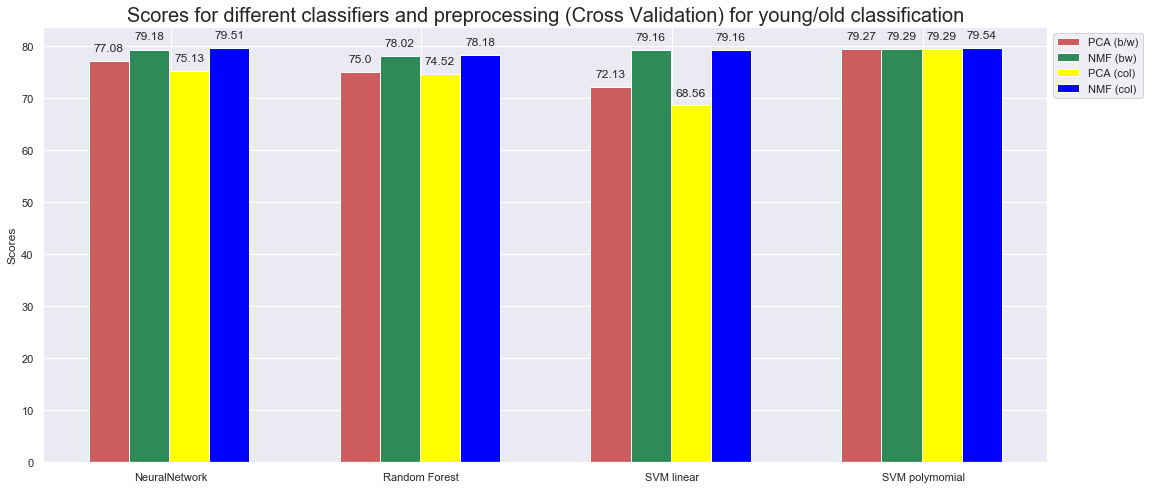

In [124]:
young_pred_bw_PCA = 100 * np.array([c1_y_bw_PCA, c2_y_bw_PCA, c3_y_bw_PCA, c4_y_bw_PCA])
young_pred_bw_NMF = 100 * np.array([c1_y_bw_NMF, c2_y_bw_NMF, c3_y_bw_NMF, c4_y_bw_NMF])
young_pred_col_PCA = 100 * np.array([c1_y_col_PCA, c2_y_col_PCA, c3_y_col_PCA, c4_y_col_PCA])
young_pred_col_NMF = 100 * np.array([c1_y_col_NMF, c2_y_col_NMF, c3_y_col_NMF, c4_y_col_NMF])




width = 0.2
N = len(young_pred_bw_NMF)
ind = np.arange(N) * 1.25  # the x locations for the groups

fig, ax = plt.subplots(figsize=(18, 8))
rects1 = ax.bar(ind, young_pred_bw_PCA, width, color='indianred')
rects2 = ax.bar(ind + width, young_pred_bw_NMF, width, color='seagreen')
rects3 = ax.bar(ind + 2*width, young_pred_col_PCA, width, color='yellow')
rects4 = ax.bar(ind + 3*width, young_pred_col_NMF, width, color='blue')
autolabel(rects1, ax)
autolabel(rects2, ax)
autolabel(rects3, ax)
autolabel(rects4, ax)

ax.set_ylabel('Scores')
ax.set_title('Scores for different classifiers and preprocessing (Cross Validation) for young/old classification', fontsize = 20)
ax.set_xticks(ind + width / .65)
ax.set_xticklabels(('NeuralNetwork', 'Random Forest', 'SVM linear', 'SVM polymomial'))
ax.legend((rects1[0], rects2[0], rects3[0], rects4[0]), 
          ('PCA (b/w)', 'NMF (bw)', 'PCA (col)', 'NMF (col)'), bbox_to_anchor=(1, 1))
plt.show()

### smiling

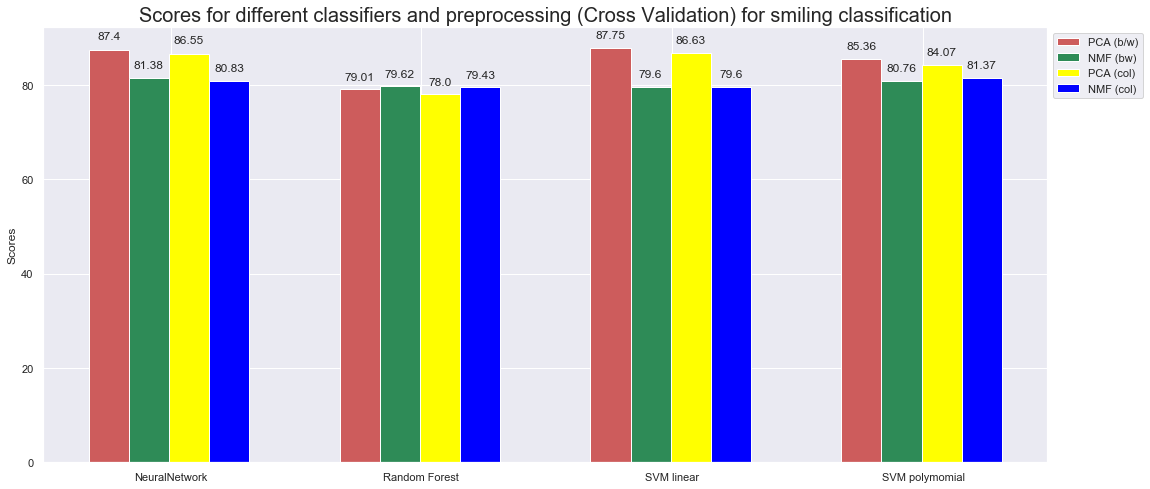

In [123]:
smiling_pred_bw_PCA = 100 * np.array([c1_s_bw_PCA, c2_s_bw_PCA, c3_s_bw_PCA, c4_s_bw_PCA])
smiling_pred_bw_NMF = 100 * np.array([c1_s_bw_NMF, c2_s_bw_NMF, c3_s_bw_NMF, c4_s_bw_NMF])
smiling_pred_col_PCA = 100 * np.array([c1_s_col_PCA, c2_s_col_PCA, c3_s_col_PCA, c4_s_col_PCA])
smiling_pred_col_NMF = 100 * np.array([c1_s_col_NMF, c2_s_col_NMF, c3_s_col_NMF, c4_s_col_NMF])




width = 0.2
N = len(smiling_pred_bw_NMF)
ind = np.arange(N) * 1.25  # the x locations for the groups

fig, ax = plt.subplots(figsize=(18, 8))
rects1 = ax.bar(ind, smiling_pred_bw_PCA, width, color='indianred')
rects2 = ax.bar(ind + width, smiling_pred_bw_NMF, width, color='seagreen')
rects3 = ax.bar(ind + 2*width, smiling_pred_col_PCA, width, color='yellow')
rects4 = ax.bar(ind + 3*width, smiling_pred_col_NMF, width, color='blue')
autolabel(rects1, ax)
autolabel(rects2, ax)
autolabel(rects3, ax)
autolabel(rects4, ax)

ax.set_ylabel('Scores')
ax.set_title('Scores for different classifiers and preprocessing (Cross Validation) for smiling classification', fontsize = 20)
ax.set_xticks(ind + width / .65)
ax.set_xticklabels(('NeuralNetwork', 'Random Forest', 'SVM linear', 'SVM polymomial'))
ax.legend((rects1[0], rects2[0], rects3[0], rects4[0]), 
          ('PCA (b/w)', 'NMF (bw)', 'PCA (col)', 'NMF (col)'), bbox_to_anchor=(1, 1))
plt.show()

### With or without eyeglasses

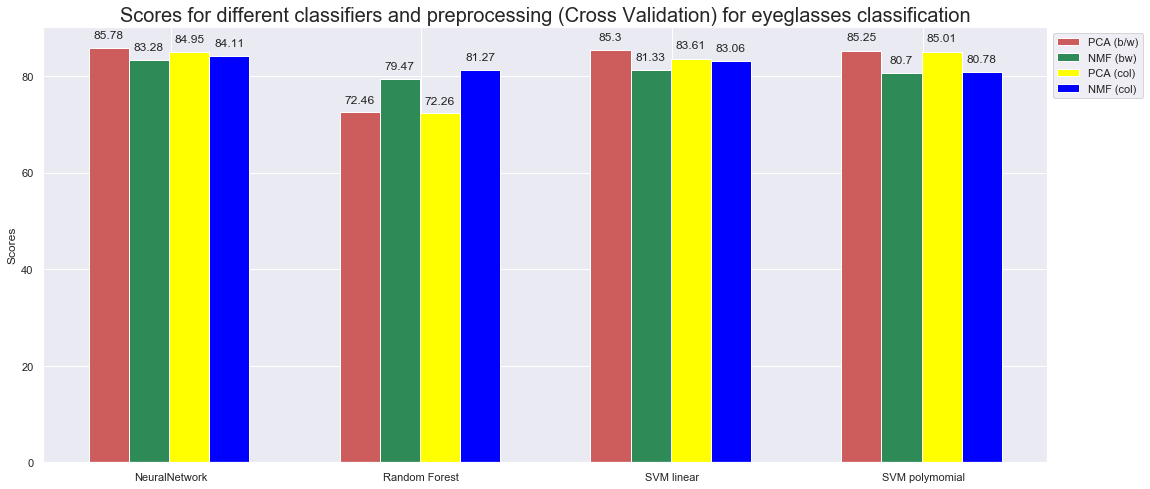

In [122]:
eyeglasses_pred_bw_PCA = 100 * np.array([c1_e_bw_PCA, c2_e_bw_PCA, c3_e_bw_PCA, c4_e_bw_PCA])
eyeglasses_pred_bw_NMF = 100 * np.array([c1_e_bw_NMF, c2_e_bw_NMF, c3_e_bw_NMF, c4_e_bw_NMF])
eyeglasses_pred_col_PCA = 100 * np.array([c1_e_col_PCA, c2_e_col_PCA, c3_e_col_PCA, c4_e_col_PCA])
eyeglasses_pred_col_NMF = 100 * np.array([c1_e_col_NMF, c2_e_col_NMF, c3_e_col_NMF, c4_e_col_NMF])




width = 0.2
N = len(eyeglasses_pred_bw_NMF)
ind = np.arange(N) * 1.25  # the x locations for the groups

fig, ax = plt.subplots(figsize=(18, 8))
rects1 = ax.bar(ind, eyeglasses_pred_bw_PCA, width, color='indianred')
rects2 = ax.bar(ind + width, eyeglasses_pred_bw_NMF, width, color='seagreen')
rects3 = ax.bar(ind + 2*width, eyeglasses_pred_col_PCA, width, color='yellow')
rects4 = ax.bar(ind + 3*width, eyeglasses_pred_col_NMF, width, color='blue')
autolabel(rects1, ax)
autolabel(rects2, ax)
autolabel(rects3, ax)
autolabel(rects4, ax)

ax.set_ylabel('Scores')
ax.set_title('Scores for different classifiers and preprocessing (Cross Validation) for eyeglasses classification', fontsize = 20)
ax.set_xticks(ind + width / .65)
ax.set_xticklabels(('NeuralNetwork', 'Random Forest', 'SVM linear', 'SVM polymomial'))
ax.legend((rects1[0], rects2[0], rects3[0], rects4[0]), 
          ('PCA (b/w)', 'NMF (bw)', 'PCA (col)', 'NMF (col)'), bbox_to_anchor=(1, 1))
plt.show()